# MSCOCO Demo
This notebook shows the inference from the YOLO v3 model I trained using MS COCO 2017 dataset.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

from yolov3 import YoloV3
from preprocess import Preprocessor
from postprocess import Postprocessor

TOTAL_CLASSES = 80
BATCH_SIZE = 1

## Prepare Test Images

In [2]:
preprocess = Preprocessor(False, TOTAL_CLASSES, (416, 416))
dataset = tf.data.Dataset.list_files('./dataset/tfrecords/val_0004_of_0008.tfrecords')
dataset = tf.data.TFRecordDataset(dataset)
dataset = dataset.map(preprocess, num_parallel_calls=1)
dataset = dataset.batch(BATCH_SIZE)
x, y_true = next(iter(dataset))

In [3]:
class_names = {}
with open('./dataset/mscoco_2017_names.txt') as fp:
    lines = fp.read().splitlines()
    for i, line in enumerate(lines):
        class_names[i] = line

## Initialize the Model

In [4]:
model = YoloV3(shape=(416, 416, 3), num_classes=TOTAL_CLASSES, training=False)
model.load_weights('./models/model-v1.0.1-epoch-56-loss-42.0143.tf')

## Run Inference

In [5]:
postprocess = Postprocessor(iou_thresh=0.5, score_thresh=0.5)
y_pred = model(x, training=False)
y_pred_nms = postprocess(y_pred)

num_predictions = y_pred_nms[3][0][0].numpy()
print('Number of predictions: ', num_predictions)

Number of predictions:  19


## Draw the Image and Bounding Boxes

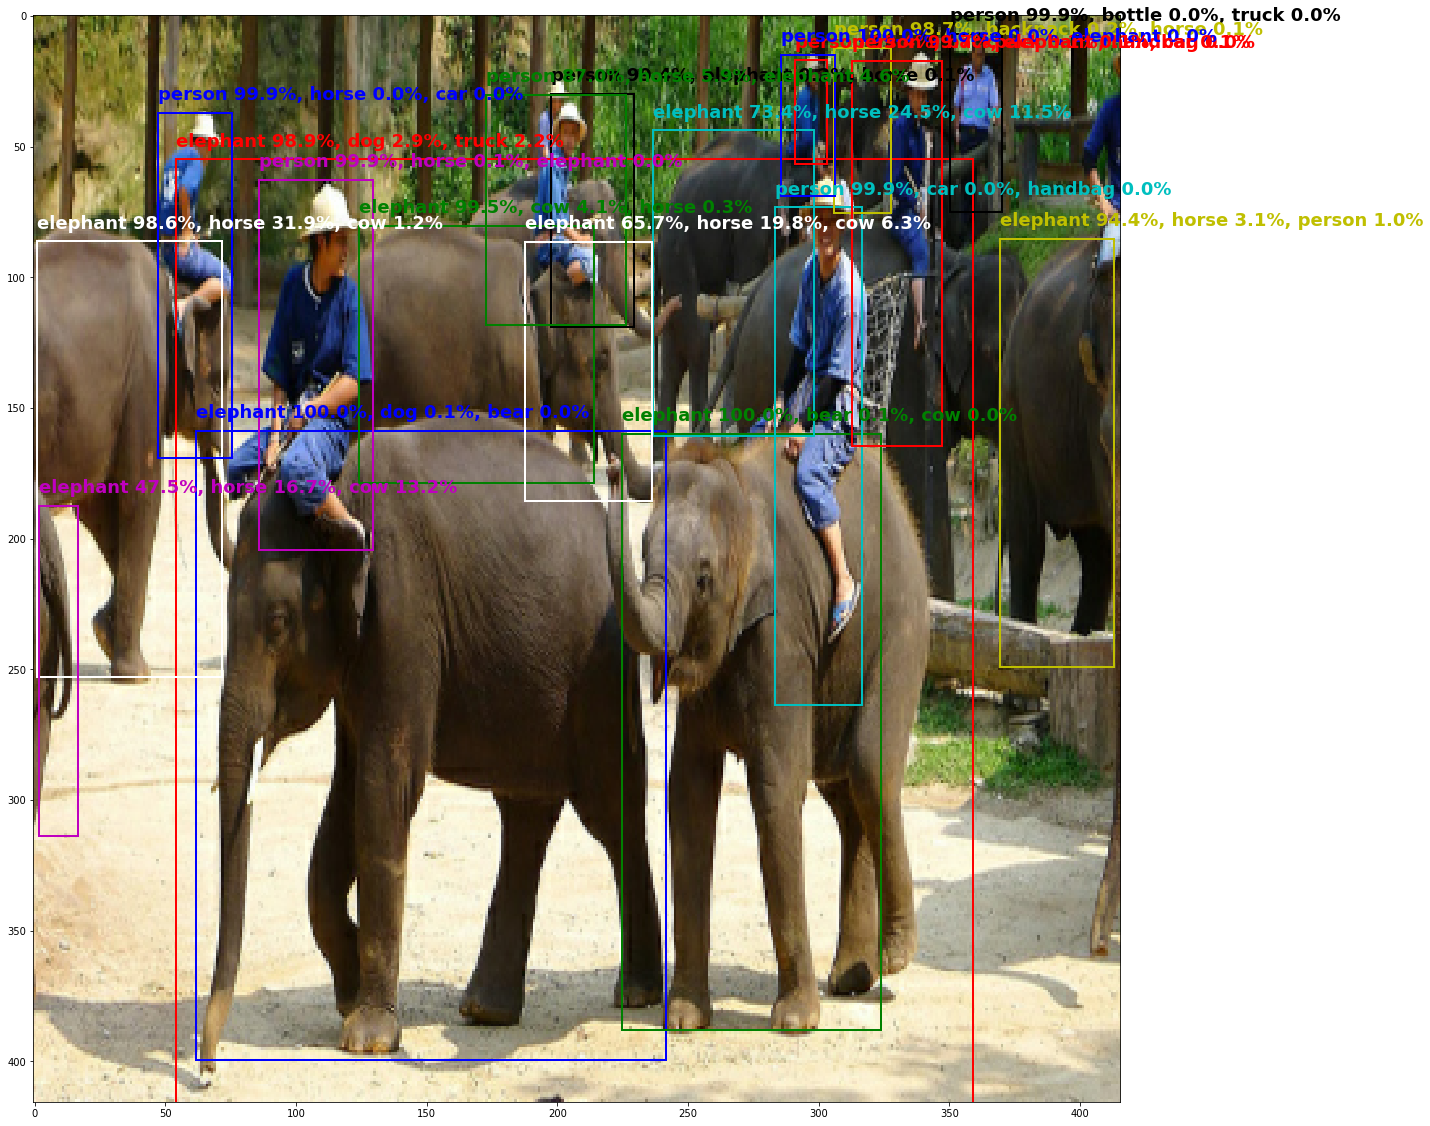

In [6]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
im = tf.cast((x[0] + 1) * 127.5, tf.int32)

plt.rcParams['figure.figsize'] = (20,20)
fig,ax = plt.subplots(1)
ax.imshow(im)
h, w, d = im.shape

for i in range(0, num_predictions):
    box = y_pred_nms[0][0][i].numpy()
    score = y_pred_nms[1][0][i][0].numpy()
    class_prob = y_pred_nms[2][0][i].numpy()
    values, indices = tf.math.top_k(class_prob, k=3)
    text= []
    for index, prob in zip(indices.numpy(), values.numpy()):
        text.append('{} {:.1f}%'.format(class_names[index], prob*100))
    text = ', '.join(text)
    xmin = box[0] * w
    ymin = box[1] * h
    width = (box[2] - box[0]) * w
    height = (box[3] - box[1]) * h
    color = colors[i % 8]
    rect = patches.Rectangle((xmin,ymin),width,height,linewidth=2,edgecolor=color,facecolor='none')
    ax.add_patch(rect)
    ax.annotate(text, (xmin, ymin - 5), color=color, weight='bold', 
                fontsize=18)

plt.show()